## 1. Настройки программы поиска лиц

In [ ]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
)
logger = logging.getLogger(__name__)

# Поддерживаемые форматы изображений
IMAGE_EXTENSIONS = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

# --- Детектор (MTCNN) ---
# Минимальный порог уверенности для детекции лица
DETECTION_CONFIDENCE = 0.95
# Минимальный размер лица в пикселях
MIN_FACE_SIZE = 20

# --- Эмбеддинги (FaceNet / InceptionResnetV1) ---
# Размер входного изображения для модели
FACE_INPUT_SIZE = 160
# Размерность эмбеддинга
EMBEDDING_DIM = 512

# --- Поиск по эталону ---
# Порог cosine similarity для признания совпадения
SEARCH_THRESHOLD = 0.6

# --- Кластеризация ---
# Метод кластеризации: "agglomerative" или "dbscan"
CLUSTER_METHOD = "agglomerative"
# Порог расстояния для AgglomerativeClustering (cosine distance = 1 - similarity)
AGGLOMERATIVE_THRESHOLD = 0.7
# Параметры DBSCAN
DBSCAN_EPS = 0.5
DBSCAN_MIN_SAMPLES = 2


## 2. Модуль детектирования лиц на фотографиях (MTCNN).

In [5]:
import os
import numpy as np
from PIL import Image
from facenet_pytorch import MTCNN
from tqdm import tqdm

def load_images(folder_path):
    """Загрузить список путей к изображениям из папки."""
    paths = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(IMAGE_EXTENSIONS):
            paths.append(os.path.join(folder_path, filename))
    return paths


def create_detector(device="cpu"):
    """Создать детектор MTCNN."""
    detector = MTCNN(
        keep_all=True,
        min_face_size=MIN_FACE_SIZE,
        thresholds=[0.6, 0.7, 0.7],  # стандартные пороги MTCNN по стадиям
        device=device,
    )
    return detector


def detect_faces_on_image(detector, image_path):
    """
    Обнаружить все лица на одном изображении.

    Возвращает список словарей:
        {
            "box": [x1, y1, x2, y2],
            "confidence": float,
            "crop": PIL.Image,      # вырезанное лицо
        }
    """
    img = Image.open(image_path).convert("RGB")
    boxes, confidences = detector.detect(img)

    faces = []
    if boxes is None:
        return faces

    img_array = np.array(img)

    for i, (box, conf) in enumerate(zip(boxes, confidences)):
        if conf < DETECTION_CONFIDENCE:
            continue

        # Координаты bounding box (приводим к int, ограничиваем границами)
        x1 = max(0, int(box[0]))
        y1 = max(0, int(box[1]))
        x2 = min(img_array.shape[1], int(box[2]))
        y2 = min(img_array.shape[0], int(box[3]))

        crop = img.crop((x1, y1, x2, y2))

        faces.append({
            "box": [x1, y1, x2, y2],
            "confidence": float(conf),
            "crop": crop,
        })

    return faces


def detect_all_faces(image_paths, device="cpu", crops_dir=None):
    """
    Обнаружить лица на всех фотографиях.

    Параметры:
        image_paths: список путей к изображениям
        device: "cpu" или "cuda"
        crops_dir: если задана — сохранить кропы лиц в эту папку

    Возвращает список словарей:
        {
            "photo_path": str,
            "photo_name": str,
            "face_index": int,
            "box": [x1, y1, x2, y2],
            "confidence": float,
            "crop": PIL.Image,
            "crop_path": str или None,
        }
    """
    detector = create_detector(device)

    if crops_dir:
        os.makedirs(crops_dir, exist_ok=True)

    all_faces = []

    for image_path in tqdm(image_paths, desc="Детектирование лиц"):
        photo_name = os.path.splitext(os.path.basename(image_path))[0]
        faces = detect_faces_on_image(detector, image_path)

        for i, face in enumerate(faces):
            crop_path = None
            if crops_dir:
                crop_path = os.path.join(crops_dir, f"{photo_name}_face_{i}.jpg")
                face["crop"].save(crop_path)

            all_faces.append({
                "photo_path": image_path,
                "photo_name": photo_name,
                "face_index": i,
                "box": face["box"],
                "confidence": face["confidence"],
                "crop": face["crop"],
                "crop_path": crop_path,
            })

    print(f"Найдено лиц: {len(all_faces)} на {len(image_paths)} фотографиях")
    return all_faces


c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Модуль извлечения эмбеддингов лиц (FaceNet / InceptionResnetV1).

In [6]:

import os
import pickle
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1
from tqdm import tqdm

import config


def create_embedder(device="cpu"):
    """Загрузить предобученную модель InceptionResnetV1."""
    model = InceptionResnetV1(pretrained="vggface2").eval().to(device)
    return model


# Предобработка изображения лица для модели
_preprocess = transforms.Compose([
    transforms.Resize((config.FACE_INPUT_SIZE, config.FACE_INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


def get_embedding(model, face_image, device="cpu"):
    """
    Получить 512-мерный эмбеддинг для одного лица.

    Параметры:
        model: InceptionResnetV1
        face_image: PIL.Image (вырезанное лицо)
        device: "cpu" или "cuda"

    Возвращает: np.ndarray формы (512,)
    """
    img_tensor = _preprocess(face_image).unsqueeze(0).to(device)

    with torch.no_grad():
        embedding = model(img_tensor)

    # L2-нормализация
    embedding = F.normalize(embedding, p=2, dim=1)
    return embedding.cpu().numpy().flatten()


def compute_embeddings(face_records, device="cpu", cache_path=None):
    """
    Вычислить эмбеддинги для всех обнаруженных лиц.

    Параметры:
        face_records: список словарей из detector.detect_all_faces()
        device: "cpu" или "cuda"
        cache_path: путь к файлу кэша (.pkl); если файл существует — загрузить

    Возвращает: np.ndarray формы (N, 512)
    """
    # Попытка загрузить из кэша
    if cache_path and os.path.exists(cache_path):
        print(f"Загрузка эмбеддингов из кэша: {cache_path}")
        with open(cache_path, "rb") as f:
            embeddings = pickle.load(f)
        if len(embeddings) == len(face_records):
            return embeddings
        print("Размер кэша не совпадает, пересчитываем...")

    model = create_embedder(device)
    embeddings = []

    for record in tqdm(face_records, desc="Извлечение эмбеддингов"):
        emb = get_embedding(model, record["crop"], device)
        embeddings.append(emb)

    embeddings = np.array(embeddings)

    # Сохранить в кэш
    if cache_path:
        os.makedirs(os.path.dirname(cache_path), exist_ok=True)
        with open(cache_path, "wb") as f:
            pickle.dump(embeddings, f)
        print(f"Эмбеддинги сохранены в кэш: {cache_path}")

    print(f"Вычислено эмбеддингов: {len(embeddings)}, размерность: {embeddings.shape[1]}")
    return embeddings


## 4. Общий пайплайн: загрузка фото -> детекция -> эмбеддинги

In [7]:
def run_pipeline(photos_folder, output_folder, cache_folder, device):
    """Общий пайплайн: загрузка фото -> детекция -> эмбеддинги."""
    # 1. Загрузка списка фотографий
    logger.info(f"Папка с фотографиями: {photos_folder}")
    image_paths = load_images(photos_folder)
    if not image_paths:
        logger.error("Фотографии не найдены!")
        return None, None, None
    logger.info(f"Найдено фотографий: {len(image_paths)}")

    # 2. Детектирование лиц
    crops_dir = os.path.join(output_folder, "face_crops")
    face_records = detect_all_faces(
        image_paths, device=device, crops_dir=crops_dir
    )
    if not face_records:
        logger.error("Лица не обнаружены ни на одной фотографии!")
        return None, None, None

    # 3. Извлечение эмбеддингов
    cache_path = os.path.join(cache_folder, "embeddings.pkl") if cache_folder else None
    embeddings = compute_embeddings(
        face_records, device=device, cache_path=cache_path
    )

    return image_paths, face_records, embeddings

## 5. Модуль поиска конкретного человека по эталонной фотографии

In [8]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def find_person(query_image_path, face_records, embeddings,
                threshold=None, device="cpu"):
    """
    Найти человека с эталонной фотографии среди всех обнаруженных лиц.

    Параметры:
        query_image_path: путь к фотографии-образцу
        face_records: список словарей (из detector.detect_all_faces)
        embeddings: np.ndarray (N, 512) — эмбеддинги всех лиц
        threshold: порог cosine similarity (по умолчанию из config)
        device: "cpu" или "cuda"

    Возвращает список совпадений (отсортирован по убыванию similarity):
        [
            {
                "photo_path": str,
                "photo_name": str,
                "box": [x1, y1, x2, y2],
                "similarity": float,
                "crop": PIL.Image,
                "crop_path": str или None,
                "face_index": int,
            },
            ...
        ]
    """
    if threshold is None:
        threshold = SEARCH_THRESHOLD

    # --- Получить эмбеддинг эталонного лица ---
    detector = create_detector(device)
    model = create_embedder(device)

    # Детектировать лица на эталонном фото
    faces = detect_faces_on_image(detector, query_image_path)

    if len(faces) == 0:
        print("На эталонной фотографии лица не найдены!")
        return []

    # Берём самое крупное лицо (по площади bounding box)
    if len(faces) > 1:
        print(f"На эталонном фото найдено {len(faces)} лиц, берём самое крупное.")

    def box_area(face):
        b = face["box"]
        return (b[2] - b[0]) * (b[3] - b[1])

    best_face = max(faces, key=box_area)
    query_embedding = get_embedding(model, best_face["crop"], device)

    # --- Сравнить с базой ---
    similarities = cosine_similarity(
        query_embedding.reshape(1, -1), embeddings
    )[0]

    # Отобрать совпадения выше порога
    matches = []
    for i, sim in enumerate(similarities):
        if sim >= threshold:
            record = face_records[i]
            matches.append({
                "photo_path": record["photo_path"],
                "photo_name": record["photo_name"],
                "box": record["box"],
                "similarity": float(sim),
                "crop": record["crop"],
                "crop_path": record.get("crop_path"),
                "face_index": record["face_index"],
            })

    # Сортировка по убыванию сходства
    matches.sort(key=lambda m: m["similarity"], reverse=True)
    print(f"Найдено совпадений: {len(matches)} (порог: {threshold})")
    return matches


## 6. Поиск конкретного человека

In [9]:
photos_folder = "../photos_БСУ"
output_folder = "results_1"
cache_folder = "cache_1"
device = "cuda"
query_path = "../86379d7c-b186-4a2b-a574-c824407e9473.jpg"
threshold = SEARCH_THRESHOLD

logger.info("=== Режим: поиск по эталону ===")

image_paths, face_records, embeddings = run_pipeline(photos_folder, output_folder, cache_folder, device)

# 4. Поиск
matches = find_person(
    query_path, face_records, embeddings,
    threshold=threshold, device=device,
)

2026-02-09 17:21:29,523 [INFO] === Режим: поиск по эталону ===
2026-02-09 17:21:29,524 [INFO] Папка с фотографиями: ../photos_БСУ
2026-02-09 17:21:29,526 [INFO] Найдено фотографий: 61
Детектирование лиц: 100%|██████████| 61/61 [00:18<00:00,  3.33it/s]


Найдено лиц: 865 на 61 фотографиях


Извлечение эмбеддингов: 100%|██████████| 865/865 [00:21<00:00, 40.99it/s]


Эмбеддинги сохранены в кэш: cache_1\embeddings.pkl
Вычислено эмбеддингов: 865, размерность: 512
Найдено совпадений: 23 (порог: 0.6)


In [10]:
matches

[{'photo_path': '../photos_БСУ\\018118118120230423-3W1A0445 (1).jpg',
  'photo_name': '018118118120230423-3W1A0445 (1)',
  'box': [401, 173, 438, 220],
  'similarity': 0.8817801475524902,
  'crop': <PIL.Image.Image image mode=RGB size=37x47>,
  'crop_path': 'results_1\\face_crops\\018118118120230423-3W1A0445 (1)_face_8.jpg',
  'face_index': 8},
 {'photo_path': '../photos_БСУ\\WhatsApp Image 2023-04-23 at 12.07.19 (1).jpeg',
  'photo_name': 'WhatsApp Image 2023-04-23 at 12.07.19 (1)',
  'box': [216, 116, 320, 243],
  'similarity': 0.8515446782112122,
  'crop': <PIL.Image.Image image mode=RGB size=104x127>,
  'crop_path': 'results_1\\face_crops\\WhatsApp Image 2023-04-23 at 12.07.19 (1)_face_1.jpg',
  'face_index': 1},
 {'photo_path': '../photos_БСУ\\011011011020230423-3W1A0070 (1).jpg',
  'photo_name': '011011011020230423-3W1A0070 (1)',
  'box': [459, 470, 519, 551],
  'similarity': 0.8505148887634277,
  'crop': <PIL.Image.Image image mode=RGB size=60x81>,
  'crop_path': 'results_1\\fac

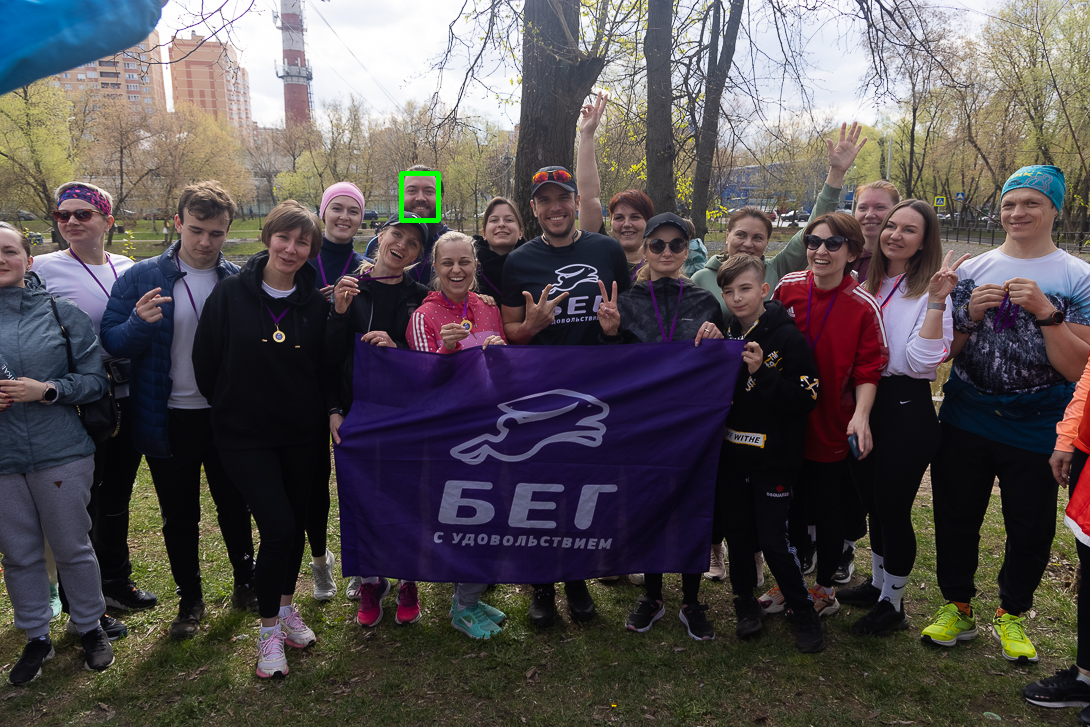

In [25]:
import cv2 as cv
import numpy as np

photo_path = matches[0]['photo_path']
box = matches[0]['box']
img = np.array(Image.open(photo_path).convert("RGB"))
img_with_box = cv.rectangle(img, (box[0], box[1]), (box[2], box[3]),  (0, 255, 0), 3)
img_with_box = Image.fromarray(img_with_box)
img_with_box